# Import PyTorch

In [35]:
import torch

# Import the dataset from Hugging Face

In [18]:
from datasets import load_dataset
dataset = load_dataset("tweet_eval", "sentiment")

# Import the necessary libraries

In [19]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import re
import evaluate
import accelerate
import json
from pathlib import Path

# Check dataset

In [20]:
print(dataset)  

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


 # View first 5 rows as a table

In [21]:
def dataset_head(ds, split="train", n=5):
    for i in range(min(n, len(ds[split]))):
        print(f"Row {i}: {ds[split][i]}")

dataset_head(dataset)

Row 0: {'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'label': 2}
Row 1: {'text': '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"', 'label': 1}
Row 2: {'text': 'Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.', 'label': 1}
Row 3: {'text': "Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays", 'label': 1}
Row 4: {'text': '@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"', 'label': 2}


# Quick EDA

# Check for empty texts

In [22]:
empty_count = sum(1 for example in dataset["train"] if not example["text"].strip())
print(f"Empty reviews: {empty_count}")

Empty reviews: 0


# Check the distribution of labels

<BarContainer object of 3 artists>

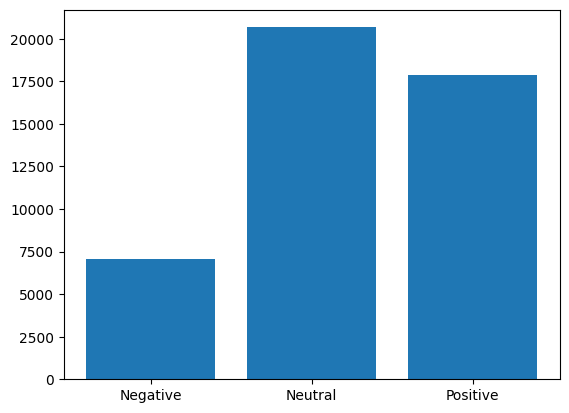

In [23]:
labels = dataset["train"]["label"]
plt.bar(["Negative", "Neutral", "Positive"], np.bincount(labels))

# Create smaller dataset for faster training and testing

In [24]:
small_train_dataset = dataset["train"].shuffle(seed=42).select([i for i in list(range(10000))])
small_test_dataset = dataset["test"].shuffle(seed=42).select([i for i in list(range(1000))])

# Twitter-optimized RoBERTa tokenizer 

In [25]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Preprocess data

In [26]:
def preprocess(text: str) -> str:

    text = re.sub(r'@\w+', '[USER]', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)
    return ' '.join(text.strip().split())

In [27]:
def preprocess(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = small_train_dataset.map(preprocess, batched=True)
tokenized_test = small_test_dataset.map(preprocess, batched=True)

#tokenized_dataset = dataset.map(preprocess, batched=True) - for entire dataset


# RoBERTa Model Setup

In [28]:
model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    num_labels=3
)

# Custom Metrics Evaluation

In [29]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")

    return {
        "accuracy": accuracy,
        "f1": f1
    }

# Define training arguments

In [30]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch"
)

# Padding collator for dynamic batch processing

In [31]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define Trainer 

In [32]:
# trainer setup for entire dataset
'''
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,  
    data_collator=data_collator
)
'''

'\ntrainer = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=tokenized_dataset["train"],\n    eval_dataset=tokenized_dataset["test"],\n    compute_metrics=compute_metrics,  \n    data_collator=data_collator\n)\n'

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)


# Training the model

In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# Compute the evaluation metrics

In [ ]:
results = trainer.evaluate()
print(f"Final Accuracy: {results['eval_accuracy']:.4f}")
print(f"Final F1-Score: {results['eval_f1']:.4f}")

Final Accuracy: 0.7240
Final F1-Score: 0.7236


# Tokenizer Save Operation in "./tokenizer" folder

In [ ]:
tokenizer.save_pretrained("./tokenizer")

('./tokenizer\\tokenizer_config.json',
 './tokenizer\\special_tokens_map.json',
 './tokenizer\\vocab.json',
 './tokenizer\\merges.txt',
 './tokenizer\\added_tokens.json',
 './tokenizer\\tokenizer.json')

# XY plot of your best checkpoint's evaluation results

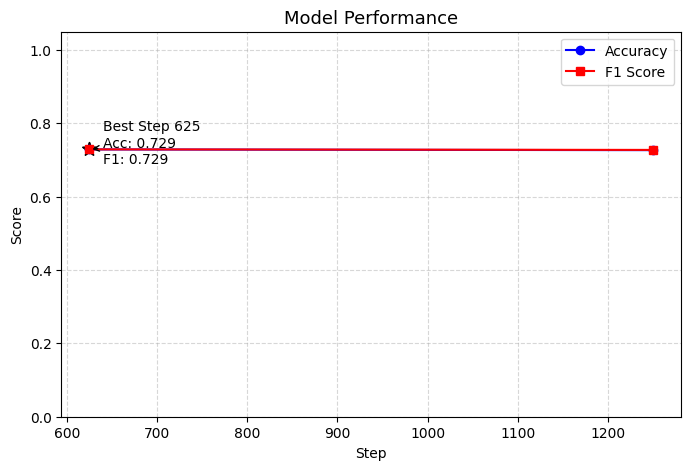

In [ ]:
log_file = next(Path("./results").glob("*/trainer_state.json"))
with open(log_file) as f:
    history = json.load(f)["log_history"]

eval_steps, accuracy, f1_scores = zip(*[(x["step"], x["eval_accuracy"], x["eval_f1"]) 
                                        for x in history if "eval_accuracy" in x and "eval_f1" in x])


best_idx = np.argmax(f1_scores)
best_step, best_acc, best_f1 = eval_steps[best_idx], accuracy[best_idx], f1_scores[best_idx]


plt.figure(figsize=(8, 5))
plt.plot(eval_steps, accuracy, 'b-o', label="Accuracy")
plt.plot(eval_steps, f1_scores, 'r-s', label="F1 Score")
plt.scatter([best_step], [best_acc], c='red', s=100, marker='*', edgecolors='black')
plt.scatter([best_step], [best_f1], c='red', s=100, marker='*', edgecolors='black')

plt.annotate(f'Best Step {best_step}\nAcc: {best_acc:.3f}\nF1: {best_f1:.3f}', 
             (best_step, best_f1), textcoords="offset points", xytext=(10, -10),
             arrowprops=dict(facecolor='black', arrowstyle="->"))

plt.title("Model Performance", fontsize=13)
plt.xlabel("Step")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.savefig("checkpoint_performance.png", dpi=300)
plt.show()

# Import our model from Hugging Face

In [ ]:
from transformers import RobertaForSequenceClassification, AutoTokenizer

model = RobertaForSequenceClassification.from_pretrained("akdfga/SenbiModel")
tokenizer = AutoTokenizer.from_pretrained("akdfga/tokenizer")

# Prediction of new sentiments 

In [ ]:
texts = ["I love Tweeter, the community is very kind #love",
         "Elon Musk is a bad person, we should cancel him #cancelculture"]

inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")


with torch.no_grad():  
    outputs = model(**inputs)


logits = outputs.logits


predicted_labels = torch.argmax(logits, dim=1).tolist()
print(predicted_labels)  

[2, 0]


* 0 - means negative
* 1 - means neutral
* 2 - means positive

